<a href="https://colab.research.google.com/github/pankajm333/Blinkit-Sales-Customer-Insights-Dashboard/blob/main/Dual-Perspective%20Fusion%20Network%20for%20Aspect-Based%20Multimodal%20Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Cell 1: Mount Google Drive and list the dataset folder ---
from google.colab import drive
import os
from pathlib import Path

# 1) Mount Drive (you will be prompted to authorize)
drive.mount('/content/drive')

# 2) Set the dataset path .

DATA_ROOT = Path("/content/drive/MyDrive/MSA/TwitterDataMABSA")


if not DATA_ROOT.exists():
    print("Provided DATA_ROOT not found at:", DATA_ROOT)
    print("Listing top-level directories in your Drive so you can copy the correct path:")
    for p in sorted(Path("/content/drive/MyDrive").iterdir()):
        print(" ", p.name)
else:
    print("DATA_ROOT found:", DATA_ROOT)

# 4) Show a small tree of the dataset folder (first two levels)
def show_tree(root: Path, max_items=50):
    print("\nContents of:", root)
    if not root.exists():
        print("  (path does not exist)")
        return
    items = sorted(list(root.iterdir()))
    for i, it in enumerate(items):
        if i >= max_items:
            print("  ... (more items omitted)")
            break
        if it.is_dir():
            print("  [DIR] ", it.name)
            # list up to 8 files inside each dir
            sub = sorted(list(it.iterdir()))[:8]
            for s in sub:
                print("     -", s.name)
        else:
            print("  [FILE]", it.name)

show_tree(DATA_ROOT)


Mounted at /content/drive
DATA_ROOT found: /content/drive/MyDrive/MSA/TwitterDataMABSA

Contents of: /content/drive/MyDrive/MSA/TwitterDataMABSA
  [FILE] README.md
  [DIR]  caption
     - twitter2015_images.json
     - twitter2017_images.json
  [DIR]  imgDealFile
     - twitter2015_images.pkl
     - twitter2017_images.pkl
  [DIR]  oriAdj
     - dev_ori_adj.pkl
     - test_ori_adj.pkl
     - train_ori_adj.pkl
  [DIR]  oriAdj17
     - dev_ori_adj.pkl
     - test_ori_adj.pkl
     - train_ori_adj.pkl
     - val_ori_adj.pkl
  [DIR]  twitter2015
     - .~lock.train.tsv#
     - deps
     - dev.json
     - dev.tsv
     - dev.txt
     - test.json
     - test.tsv
     - test.txt
  [DIR]  twitter2015_images
     - 0.jpg
     - 1000046.jpg
     - 1000120.jpg
     - 10005.jpg
     - 1001621.jpg
     - 1001683.jpg
     - 1001880.jpg
     - 1002711.jpg
  [DIR]  twitter2017
     - deps
     - dev.json
     - dev.tsv
     - dev.txt
     - test.json
     - test.tsv
     - test.txt
     - train.json
  [D

In [ ]:
# --- Cell 2: Clone DPFN repo, install dependencies, and link dataset ---

# 1️⃣ Clone the official DPFN code repository from GitHub
!git clone https://github.com/cntian0/DPFN.git /content/DPFN

# 2️⃣ Move into the repo directory
%cd /content/DPFN

# 3️⃣ Install dependencies (PyTorch, Transformers, Timm, SpaCy, etc.)
!pip install torch torchvision torchaudio --quiet
!pip install transformers timm sentencepiece spacy --quiet
!python -m spacy download en_core_web_sm --quiet

# 4️⃣ (Optional) Check if requirements.txt exists in the repo and install it
import os
if os.path.exists("requirements.txt"):
    !pip install -r requirements.txt --quiet
else:
    print("requirements.txt not found — installed core packages manually.")

# 5️⃣ Link your dataset directory to the repo (so code sees it in ./data)
!ln -s /content/drive/MyDrive/MSA/TwitterDataMABSA /content/DPFN/data

# 6️⃣ Verify that data is linked correctly
!ls -R data | head -40


Cloning into '/content/DPFN'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 68 (delta 22), reused 68 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 157.71 KiB | 2.77 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/DPFN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 84.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
requirements.txt not found — installed core packages manually.
data:
caption
imgDealFile
oriAdj
oriAdj17
README.md
twitter2015
twitter2015_images
twitter2017
twitter2017_images

data/caption:
twitter2015_images.json
twitter2017

In [ ]:
# --- Cell 3A: Inspect twitter2015 train.tsv structure ---

import pandas as pd
from pathlib import Path

file_path = Path("/content/DPFN/data/twitter2015/train.tsv")

# Read first few rows with no headers
df_preview = pd.read_csv(file_path, sep='\t', header=None)
print("Shape:", df_preview.shape)
print("\nFirst 5 rows:")
print(df_preview.head(5))

print("\nColumn count:", len(df_preview.columns))


Shape: (3180, 5)

First 5 rows:
       0         1            2  \
0  index  #1 Label   #2 ImageID   
1      1         2  1860693.jpg   
2      2         1  1860693.jpg   
3      3         1   195984.jpg   
4      4         0   195984.jpg   

                                                   3                     4  
0                                          #3 String             #3 String  
1        RT @ ltsChuckBass : $T$ is everything # MCM            Chuck Bass  
2   RT @ ltsChuckBass : Chuck Bass is everything $T$                 # MCM  
3    $T$ September 7 - - - - Shut Down New York City  Millions For Trayvon  
4  Millions For Trayvon September 7 - - - - Shut ...         New York City  

Column count: 5


In [ ]:
# --- Cell 3D: Robust conversion (handles 4 or 5 columns) ---

import csv, json
from pathlib import Path

base_path = Path("/content/DPFN/data")
datasets = ["twitter2015", "twitter2017"]

def label_to_text(num):
    mapping = {"0": "negative", "1": "neutral", "2": "positive"}
    return mapping.get(str(num).strip(), "neutral")

def convert_tsv_flexible(folder):
    folder_path = base_path / folder
    for split in ["train", "dev", "test"]:
        tsv_file = folder_path / f"{split}.tsv"
        if not tsv_file.exists():
            print(f"⚠️ Skipping {tsv_file} (not found)")
            continue

        data_json = []
        with open(tsv_file, 'r', encoding='utf-8') as f:
            reader = csv.reader(f, delimiter='\t')
            header = next(reader, None)  # skip header line

            for i, row in enumerate(reader):
                if len(row) < 4:
                    continue  # skip malformed lines

                # Handle both 4-column and 5-column cases
                if len(row) == 5:
                    idx, label, image, text, aspect = row
                elif len(row) == 4:
                    # sometimes the 'aspect' is missing; set to empty
                    idx, label, image, text = row
                    aspect = ""
                else:
                    # any longer/shorter rows, try to fit pattern
                    idx = row[0]
                    label = row[1] if len(row) > 1 else "1"
                    image = row[2] if len(row) > 2 else ""
                    text = row[3] if len(row) > 3 else ""
                    aspect = row[4] if len(row) > 4 else ""

                # clean up
                clean_text = str(text).replace("$T$", str(aspect))
                data_json.append({
                    "id": str(idx),
                    "text": clean_text,
                    "aspect": str(aspect),
                    "label": label_to_text(label),
                    "image": str(image)
                })

        out_file = folder_path / f"{split}.json"
        with open(out_file, "w", encoding="utf-8") as f:
            json.dump(data_json, f, ensure_ascii=False, indent=2)
        print(f"✅ Saved {split}.json ({len(data_json)} samples) to {out_file}")

for d in datasets:
    convert_tsv_flexible(d)


✅ Saved train.json (3179 samples) to /content/DPFN/data/twitter2015/train.json
✅ Saved dev.json (1122 samples) to /content/DPFN/data/twitter2015/dev.json
✅ Saved test.json (1037 samples) to /content/DPFN/data/twitter2015/test.json
✅ Saved train.json (3562 samples) to /content/DPFN/data/twitter2017/train.json
✅ Saved dev.json (1176 samples) to /content/DPFN/data/twitter2017/dev.json
✅ Saved test.json (1234 samples) to /content/DPFN/data/twitter2017/test.json


In [ ]:
# --- Cell 4 (improved): Extract ViT image features with checkpoint/resume ---

from pathlib import Path
import torch
from torchvision import transforms
from PIL import Image
import timm
from tqdm import tqdm
import os

# Paths
base_path = Path("/content/DPFN/data")
datasets = ["twitter2015", "twitter2017"]

# 1️⃣ Load pretrained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()
if torch.cuda.is_available():
    model = model.cuda()
print("✅ ViT model loaded and ready.")

# 2️⃣ Define preprocessing transforms (match ViT training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# 3️⃣ Function with checkpoint/resume logic
def extract_vit_features(dataset_name, save_every=100):
    img_dir = base_path / f"{dataset_name}_images"
    out_file = base_path / dataset_name / "vit_feats.pt"

    # --- Load existing checkpoint if present
    if out_file.exists():
        print(f"🟢 Loading existing checkpoint from {out_file}")
        all_features = torch.load(out_file)
        processed = set(all_features.keys())
        print(f"✅ {len(processed)} images already processed — will skip them.")
    else:
        all_features, processed = {}, set()

    img_files = sorted([p for p in img_dir.glob("*.jpg")])
    print(f"🔍 Found {len(img_files)} images for {dataset_name}")

    new_count = 0
    for img_path in tqdm(img_files):
        if img_path.name in processed:
            continue  # skip already done
        try:
            img = Image.open(img_path).convert("RGB")
            tensor = transform(img).unsqueeze(0)
            if torch.cuda.is_available():
                tensor = tensor.cuda()
            with torch.no_grad():
                feat = model.forward_features(tensor)
                feat = feat.mean(dim=1).squeeze().cpu()
            all_features[img_path.name] = feat
            new_count += 1
        except Exception as e:
            print(f"⚠️ Skipping {img_path.name}: {e}")
            continue

        # --- Save checkpoint every N new images
        if new_count % save_every == 0:
            torch.save(all_features, out_file)
            print(f"💾 Checkpoint saved ({len(all_features)} features so far)")

    # --- Final save
    torch.save(all_features, out_file)
    print(f"✅ Finished {dataset_name}: total {len(all_features)} features saved to {out_file}")

# 4️⃣ Run for both datasets
for d in datasets:
    extract_vit_features(d, save_every=100)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ ViT model loaded and ready.
🟢 Loading existing checkpoint from /content/DPFN/data/twitter2015/vit_feats.pt
✅ 8288 images already processed — will skip them.
🔍 Found 8288 images for twitter2015


100%|██████████| 8288/8288 [00:00<00:00, 1193107.89it/s]


✅ Finished twitter2015: total 8288 features saved to /content/DPFN/data/twitter2015/vit_feats.pt
🟢 Loading existing checkpoint from /content/DPFN/data/twitter2017/vit_feats.pt
✅ 4461 images already processed — will skip them.
🔍 Found 4819 images for twitter2017


 60%|█████▉    | 2886/4819 [00:00<00:00, 16924.55it/s]

⚠️ Skipping O_1004.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1004.jpg'
⚠️ Skipping O_1019.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1019.jpg'
⚠️ Skipping O_1039.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1039.jpg'
⚠️ Skipping O_1057.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1057.jpg'
⚠️ Skipping O_1079.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1079.jpg'
⚠️ Skipping O_1116.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1116.jpg'
⚠️ Skipping O_112.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_112.jpg'
⚠️ Skipping O_1123.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1123.jpg'
⚠️ Skipping O_1132.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1132.jpg'
⚠️ Skipping O_116.jpg: cannot identify image file '/content/DPFN/data/twitter2017_im

 66%|██████▌   | 3183/4819 [00:32<00:23, 70.57it/s]   

⚠️ Skipping O_1592.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1592.jpg'


 66%|██████▌   | 3185/4819 [00:38<00:29, 55.96it/s]

⚠️ Skipping O_1597.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1597.jpg'
⚠️ Skipping O_16.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_16.jpg'


 66%|██████▌   | 3191/4819 [00:58<00:56, 28.68it/s]

⚠️ Skipping O_1618.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1618.jpg'


 66%|██████▌   | 3192/4819 [01:15<01:30, 17.97it/s]

⚠️ Skipping O_1622.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1622.jpg'


 66%|██████▋   | 3194/4819 [01:15<01:30, 17.88it/s]

⚠️ Skipping O_1629.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1629.jpg'
⚠️ Skipping O_1631.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1631.jpg'
⚠️ Skipping O_1636.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1636.jpg'
⚠️ Skipping O_1637.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1637.jpg'
⚠️ Skipping O_1638.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1638.jpg'
⚠️ Skipping O_1651.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1651.jpg'
⚠️ Skipping O_1655.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1655.jpg'
⚠️ Skipping O_166.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_166.jpg'
⚠️ Skipping O_1709.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1709.jpg'
⚠️ Skipping O_1712.jpg: cannot identify image file '/content/DPFN/data/twitter2017_i

 74%|███████▍  | 3574/4819 [01:16<00:36, 33.96it/s]

⚠️ Skipping O_2083.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2083.jpg'
⚠️ Skipping O_2099.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2099.jpg'
⚠️ Skipping O_2110.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2110.jpg'
⚠️ Skipping O_2132.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2132.jpg'
⚠️ Skipping O_2134.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2134.jpg'
⚠️ Skipping O_2144.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2144.jpg'
⚠️ Skipping O_2165.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2165.jpg'
⚠️ Skipping O_2174.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2174.jpg'
⚠️ Skipping O_2239.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2239.jpg'
⚠️ Skipping O_2249.jpg: cannot identify image file '/content/DPFN/data/twitter2017

 85%|████████▍ | 4089/4819 [01:16<00:10, 72.07it/s]

⚠️ Skipping O_2879.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2879.jpg'
⚠️ Skipping O_2886.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2886.jpg'
⚠️ Skipping O_2889.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2889.jpg'
⚠️ Skipping O_2890.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2890.jpg'
⚠️ Skipping O_290.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_290.jpg'
⚠️ Skipping O_2902.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2902.jpg'
⚠️ Skipping O_2903.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2903.jpg'
⚠️ Skipping O_2905.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2905.jpg'
⚠️ Skipping O_295.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_295.jpg'
⚠️ Skipping O_2955.jpg: cannot identify image file '/content/DPFN/data/twitter2017_ima

 96%|█████████▋| 4650/4819 [01:16<00:01, 154.91it/s]

⚠️ Skipping O_399.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_399.jpg'
⚠️ Skipping O_3991.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3991.jpg'
⚠️ Skipping O_400.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_400.jpg'
⚠️ Skipping O_4005.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4005.jpg'
⚠️ Skipping O_4031.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4031.jpg'
⚠️ Skipping O_4039.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4039.jpg'
⚠️ Skipping O_4057.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4057.jpg'
⚠️ Skipping O_4060.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4060.jpg'
⚠️ Skipping O_4080.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4080.jpg'
⚠️ Skipping O_4094.jpg: cannot identify image file '/content/DPFN/data/twitter2017_ima

100%|██████████| 4819/4819 [01:16<00:00, 62.80it/s] 


⚠️ Skipping O_936.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_936.jpg'
⚠️ Skipping O_937.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_937.jpg'
⚠️ Skipping O_939.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_939.jpg'
⚠️ Skipping O_94.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_94.jpg'
⚠️ Skipping O_948.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_948.jpg'
⚠️ Skipping O_96.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_96.jpg'
⚠️ Skipping O_962.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_962.jpg'
⚠️ Skipping O_972.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_972.jpg'
⚠️ Skipping O_976.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_976.jpg'
⚠️ Skipping O_98.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_98.jpg'
⚠️ Ski

In [ ]:
# --- Cell 5: Generate dependency adjacency graphs for text (syntax) ---

import spacy
import json
from pathlib import Path
from tqdm import tqdm
import numpy as np

# Load spaCy English model (we already downloaded it earlier)
nlp = spacy.load("en_core_web_sm")

# Base path to datasets
base_path = Path("/content/DPFN/data")
datasets = ["twitter2015", "twitter2017"]

def build_dependency_graph(text):
    """
    Create a soft adjacency matrix (A_ij = 1 if word i depends on j or vice versa).
    """
    doc = nlp(text)
    n = len(doc)
    if n == 0:
        return np.zeros((1, 1)).tolist()

    adj = np.zeros((n, n))
    for token in doc:
        adj[token.i][token.i] = 1  # self-loop
        for child in token.children:
            adj[token.i][child.i] = 1
            adj[child.i][token.i] = 1
    return adj.tolist()

def process_dataset(dataset_name):
    ds_path = base_path / dataset_name
    out_dir = ds_path / "deps"
    out_dir.mkdir(exist_ok=True)
    print(f"\n🔍 Building dependency graphs for {dataset_name} ...")

    for split in ["train", "dev", "test"]:
        in_file = ds_path / f"{split}.json"
        if not in_file.exists():
            print(f"⚠️ Skipping {in_file} (not found)")
            continue

        with open(in_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        graphs = []
        for item in tqdm(data, desc=f"{dataset_name}-{split}"):
            text = item["text"]
            adj = build_dependency_graph(text)
            graphs.append(adj)

        out_file = out_dir / f"{split}_deps.json"
        with open(out_file, "w", encoding="utf-8") as f:
            json.dump(graphs, f)
        print(f"✅ Saved {split}_deps.json with {len(graphs)} graphs")

for d in datasets:
    process_dataset(d)

print("\n✅ All dependency graphs created successfully!")



🔍 Building dependency graphs for twitter2015 ...


twitter2015-train: 100%|██████████| 3179/3179 [00:24<00:00, 127.75it/s]


✅ Saved train_deps.json with 3179 graphs


twitter2015-dev: 100%|██████████| 1122/1122 [00:08<00:00, 128.87it/s]


✅ Saved dev_deps.json with 1122 graphs


twitter2015-test: 100%|██████████| 1037/1037 [00:07<00:00, 140.74it/s]


✅ Saved test_deps.json with 1037 graphs

🔍 Building dependency graphs for twitter2017 ...


twitter2017-train:  99%|█████████▊| 3510/3562 [00:25<00:00, 163.39it/s]

In [ ]:
# 🔍 Extract ViT image features for Twitter15 & Twitter17 datasets
# This step creates vit_feats.pt files in their respective data folders.

import torch
from transformers import ViTModel, ViTImageProcessor
from PIL import Image
import os
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the ViT model (same as paper: ViT-B/16 pretrained on ImageNet)
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)
model.eval()

def extract_vit_features(image_dir, output_path):
    all_feats = {}
    for img_name in tqdm(os.listdir(image_dir), desc=f"Extracting from {image_dir}"):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue
        img_path = os.path.join(image_dir, img_name)
        try:
            image = Image.open(img_path).convert("RGB")
            inputs = processor(images=image, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                feat = outputs.last_hidden_state.mean(dim=1).squeeze().cpu()
            all_feats[img_name] = feat
        except Exception as e:
            print(f"⚠️ Skipping {img_name}: {e}")
    torch.save(all_feats, output_path)
    print(f"✅ Saved ViT features → {output_path}")

# Twitter15
extract_vit_features(
    "data/twitter2015_images",
    "data/twitter2015/vit_feats.pt"
)

# Twitter17
extract_vit_features(
    "data/twitter2017_images",
    "data/twitter2017/vit_feats.pt"
)

print("🎯 All visual features extracted successfully!")


In [ ]:
# 🖼️ Generate image captions (with checkpointing) for Twitter2015 & Twitter2017 datasets
# Uses BLIP image captioning model from Salesforce

from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import json
import os
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
model.eval()

def generate_captions_with_checkpoints(image_dir, output_json, checkpoint_every=200):
    """
    Generate captions for all images in image_dir and save progress periodically.
    """
    os.makedirs(os.path.dirname(output_json), exist_ok=True)

    # Load checkpoint if exists
    captions = {}
    if os.path.exists(output_json):
        print(f"🟡 Found existing checkpoint: {output_json}")
        with open(output_json, "r") as f:
            captions = json.load(f)
        print(f"↩️ Resuming from {len(captions)} already processed images.")

    img_files = sorted([
        img for img in os.listdir(image_dir)
        if img.lower().endswith((".jpg", ".jpeg", ".png"))
    ])

    # Filter unprocessed images
    remaining_imgs = [img for img in img_files if img not in captions]

    if not remaining_imgs:
        print(f"✅ All images already captioned for {image_dir}")
        return

    print(f"🚀 Starting caption generation for {len(remaining_imgs)} images in {image_dir}")

    for idx, img_name in enumerate(tqdm(remaining_imgs, desc=f"Captioning {os.path.basename(image_dir)}")):
        img_path = os.path.join(image_dir, img_name)
        try:
            raw_image = Image.open(img_path).convert("RGB")
            inputs = processor(raw_image, return_tensors="pt").to(device)
            with torch.no_grad():
                out = model.generate(**inputs, max_new_tokens=20)
            caption = processor.decode(out[0], skip_special_tokens=True)
            captions[img_name] = caption
        except Exception as e:
            print(f"⚠️ Skipping {img_name}: {e}")
            continue

        # Periodically save progress
        if (idx + 1) % checkpoint_every == 0:
            with open(output_json, "w") as f:
                json.dump(captions, f, indent=2)
            print(f"💾 Checkpoint saved after {idx + 1} images → {output_json}")

    # Final save
    with open(output_json, "w") as f:
        json.dump(captions, f, indent=2)

    print(f"🎯 Finished! Total captions saved → {len(captions)} in {output_json}")


# ---- Run for both datasets ----
generate_captions_with_checkpoints(
    "data/twitter2015_images", "data/caption/twitter2015_images.json", checkpoint_every=200
)

generate_captions_with_checkpoints(
    "data/twitter2017_images", "data/caption/twitter2017_images.json", checkpoint_every=200
)

print("✅ All captions generated with checkpointing enabled!")


In [ ]:
# Next step: create + save dataloaders used by train.py
# Run this cell in the repo root (where data_utils.py is).

import os
import pickle
from data_utils import creatr_data_loader    # uses the function already in your repo
from pathlib import Path

# Config (match defaults used in your train.py)
MAX_LEN = 50
BATCH_SIZE = 32

# Map "short" dataset keys (what train.py expects) to actual data folder names
dataset_map = {
    "twitter15": "twitter2015",  # train.py expects 'twitter15' but files live under data/twitter2015
    "twitter17": "twitter2017"
}

dataset_files = {
    'twitter15': {
        'train': 'data/twitter2015/train.tsv',
        'dev':   'data/twitter2015/dev.tsv',
        'test':  'data/twitter2015/test.tsv'
    },
    'twitter17': {
        'train': 'data/twitter2017/train.tsv',
        'dev':   'data/twitter2017/dev.tsv',
        'test':  'data/twitter2017/test.tsv'
    }
}

# output folder for pickles (train.py expects middleFile/*.pkl)
out_dir = Path("middleFile")
out_dir.mkdir(exist_ok=True)

def build_and_save(dataset_key):
    files = dataset_files[dataset_key]
    short = "twitter15" if dataset_key=="twitter15" else "twitter17"
    # filenames expected by your train.py
    train_pkl = out_dir / f"{short}_train_datas.pkl"
    dev_pkl   = out_dir / f"{short}_val_datas.pkl"
    test_pkl  = out_dir / f"{short}_test_datas.pkl"

    # Train
    if train_pkl.exists():
        print(f"✅ Already exists: {train_pkl}  (skipping creation)")
    else:
        print(f"🔧 Building train dataloader for {dataset_key} from {files['train']}")
        try:
            train_loader = creatr_data_loader(files['train'], 'train', MAX_LEN, BATCH_SIZE)
            with open(train_pkl, "wb") as f:
                pickle.dump(train_loader, f)
            print(f"💾 Saved -> {train_pkl}  (contains train dataloader)")
        except Exception as e:
            print(f"❌ Failed to build/save train loader for {dataset_key}: {e}")

    # Dev
    if dev_pkl.exists():
        print(f"✅ Already exists: {dev_pkl}  (skipping creation)")
    else:
        print(f"🔧 Building dev dataloader for {dataset_key} from {files['dev']}")
        try:
            dev_loader = creatr_data_loader(files['dev'], 'dev', MAX_LEN, BATCH_SIZE)
            with open(dev_pkl, "wb") as f:
                pickle.dump(dev_loader, f)
            print(f"💾 Saved -> {dev_pkl}  (contains dev dataloader)")
        except Exception as e:
            print(f"❌ Failed to build/save dev loader for {dataset_key}: {e}")

    # Test
    if test_pkl.exists():
        print(f"✅ Already exists: {test_pkl}  (skipping creation)")
    else:
        print(f"🔧 Building test dataloader for {dataset_key} from {files['test']}")
        try:
            test_loader = creatr_data_loader(files['test'], 'test', MAX_LEN, BATCH_SIZE)
            with open(test_pkl, "wb") as f:
                pickle.dump(test_loader, f)
            print(f"💾 Saved -> {test_pkl}  (contains test dataloader)")
        except Exception as e:
            print(f"❌ Failed to build/save test loader for {dataset_key}: {e}")

# Run for both datasets
for key in ("twitter15", "twitter17"):
    print("="*60)
    print(f"Processing dataset: {key}")
    build_and_save(key)
print("="*60)
print("All done — middleFile pickles should now be available for train.py")


In [ ]:
# 🧠 Convert ViT features (vit_feats.pt) to .pkl files expected by data_utils.py

import torch
import pickle
import os

os.makedirs("data/imgDealFile", exist_ok=True)

# Twitter2015
vit_feats_2015 = torch.load("data/twitter2015/vit_feats.pt", map_location="cpu")
with open("data/imgDealFile/twitter2015_images.pkl", "wb") as f:
    pickle.dump(vit_feats_2015, f)
print(f"✅ Saved → data/imgDealFile/twitter2015_images.pkl  ({len(vit_feats_2015)} images)")

# Twitter2017
vit_feats_2017 = torch.load("data/twitter2017/vit_feats.pt", map_location="cpu")
with open("data/imgDealFile/twitter2017_images.pkl", "wb") as f:
    pickle.dump(vit_feats_2017, f)
print(f"✅ Saved → data/imgDealFile/twitter2017_images.pkl  ({len(vit_feats_2017)} images)")


In [ ]:
# 🔧 Convert dependency JSONs to adjacency matrix pickles (.pkl)
# Robust version for mixed or malformed edges

import json, pickle, os
import numpy as np
from tqdm import tqdm

datasets = {
    "twitter2015": "data/oriAdj",
    "twitter2017": "data/oriAdj17"
}

for dataset, out_dir in datasets.items():
    os.makedirs(out_dir, exist_ok=True)
    print(f"\nProcessing {dataset} → saving to {out_dir}/")

    for split in ["train", "dev", "test"]:
        dep_path = f"data/{dataset}/deps/{split}_deps.json"
        adj_path = f"{out_dir}/{split}_ori_adj.pkl"

        if not os.path.exists(dep_path):
            print(f"⚠️ Missing file: {dep_path} — skipping")
            continue

        with open(dep_path, "r") as f:
            deps = json.load(f)

        adj_matrices = []
        for graph in tqdm(deps, desc=f"{dataset}-{split}"):
            try:
                tokens = graph[0]  # tokens list
                edges = graph[1]   # edge pairs
            except Exception:
                continue  # skip malformed graphs

            length = len(tokens)
            adj = np.zeros((length, length), dtype=int)

            for e in edges:
                # Ensure each edge is a valid 2-element list/tuple of ints
                if isinstance(e, (list, tuple)) and len(e) == 2:
                    head, dep = e
                    if isinstance(head, (int, float)) and isinstance(dep, (int, float)):
                        head, dep = int(head), int(dep)
                        if 0 <= head < length and 0 <= dep < length:
                            adj[head][dep] = 1
                            adj[dep][head] = 1  # undirected
                # Ignore invalid items (floats, strings, etc.)
                else:
                    continue

            adj_matrices.append(adj)

        with open(adj_path, "wb") as f:
            pickle.dump(adj_matrices, f)

        print(f"✅ Saved → {adj_path} ({len(adj_matrices)} graphs)")

print("\n🎯 All adjacency matrices generated successfully!")


In [ ]:
import os

# === Define all required paths ===
base_dir = "data"
required_structure = {
    "twitter2015": [
        "train.tsv", "dev.tsv", "test.tsv", "vit_feats.pt", "deps/train_deps.json"
    ],
    "twitter2017": [
        "train.tsv", "dev.tsv", "test.tsv", "vit_feats.pt", "deps/train_deps.json"
    ],
    "caption": [
        "twitter2015_images.json", "twitter2017_images.json"
    ],
    "imgDealFile": [
        "twitter2015_images.pkl", "twitter2017_images.pkl"
    ],
    "oriAdj": [
        "train_ori_adj.pkl", "dev_ori_adj.pkl", "test_ori_adj.pkl"
    ],
    "oriAdj17": [
        "train_ori_adj.pkl", "dev_ori_adj.pkl", "test_ori_adj.pkl"
    ]
}

# === Check paths ===
print("🔍 Verifying DPFN Data Setup...\n")

def check_file(path):
    return os.path.exists(path) and os.path.isfile(path)

def check_folder(path):
    return os.path.exists(path) and os.path.isdir(path)

for folder, files in required_structure.items():
    folder_path = os.path.join(base_dir, folder)
    if not check_folder(folder_path):
        print(f"❌ Missing folder: {folder_path}")
        continue
    else:
        print(f"✅ Folder exists: {folder_path}")

    for file in files:
        file_path = os.path.join(folder_path, file)
        if check_file(file_path):
            print(f"   ✅ {file}")
        else:
            print(f"   ❌ Missing: {file}")

print("\n✅ Verification complete.")


🔍 Verifying DPFN Data Setup...

✅ Folder exists: data/twitter2015
   ✅ train.tsv
   ✅ dev.tsv
   ✅ test.tsv
   ✅ vit_feats.pt
   ✅ deps/train_deps.json
✅ Folder exists: data/twitter2017
   ✅ train.tsv
   ✅ dev.tsv
   ✅ test.tsv
   ✅ vit_feats.pt
   ✅ deps/train_deps.json
✅ Folder exists: data/caption
   ✅ twitter2015_images.json
   ✅ twitter2017_images.json
✅ Folder exists: data/imgDealFile
   ✅ twitter2015_images.pkl
   ✅ twitter2017_images.pkl
✅ Folder exists: data/oriAdj
   ✅ train_ori_adj.pkl
   ✅ dev_ori_adj.pkl
   ✅ test_ori_adj.pkl
✅ Folder exists: data/oriAdj17
   ✅ train_ori_adj.pkl
   ✅ dev_ori_adj.pkl
   ✅ test_ori_adj.pkl

✅ Verification complete.


In [ ]:
%cd /content/drive/MyDrive/MSA/DPFN-main
# !python train.py


/content/drive/.shortcut-targets-by-id/1GaB_yvMfGSE15Qh-B1q20KQ_dN-akKcn/MSA/DPFN-main


In [ ]:
!ls -R /content/DPFN

In [ ]:
!mkdir -p /content/DPFN/data/imgDealFile \
          /content/DPFN/data/caption \
          /content/DPFN/data/oriAdj \
          /content/DPFN/data/oriAdj17 \
          /content/DPFN/middleFile \
          /content/DPFN/checkpoints \
          /content/DPFN/result


In [ ]:
# !ls -R /content/DPFN/data


In [ ]:
!python img_deal_by_vit.py


2025-12-08 05:57:29.771683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765173449.798250    1184 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765173449.806013    1184 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765173449.826969    1184 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765173449.827024    1184 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765173449.827029    1184 computation_placer.cc:177] computation placer alr

In [ ]:
!python train.py --dataset twitter15 --EPOCHS 10 --BATCH_SIZE 16 --LEARNING_RATE 5e-5


Traceback (most recent call last):
  File "/content/drive/.shortcut-targets-by-id/1GaB_yvMfGSE15Qh-B1q20KQ_dN-akKcn/MSA/DPFN-main/train.py", line 9, in <module>
  File "/usr/local/lib/python3.12/dist-packages/torch/__init__.py", line 2076, in <module>
    from torch import amp as amp, random as random, serialization as serialization
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 23, in <module>
    from torch._sources import get_source_lines_and_file
  File "<frozen importlib._bootstrap>", line 1357, in _find_and_load
  File "<frozen importlib._bootstrap>", line 417, in __enter__
  File "<frozen importlib._bootstrap>", line 432, in _get_module_lock
KeyboardInterrupt
^C


In [ ]:
import pandas as pd

test_path = "data/twitter2015/test.tsv"
df = pd.read_csv(test_path, sep="\t")
print("✅ Columns in test.tsv:")
print(df.columns.tolist())
print("\nFirst 3 rows:")
print(df.head(3))


✅ Columns in test.tsv:
['index', '#1 ImageID', '#2 String', '#2 String.1']

First 3 rows:
   index   #1 ImageID                                          #2 String  \
1      1    74960.jpg  RT @ OU Football : Practice one in the books W...   
2      2  1739565.jpg          Crazy hair day ! $T$ is a contender . : )   
3      1   664451.jpg  RT @ HistoryNeedsYou : Mother and child # art ...   

        #2 String.1  
1          Oklahoma  
2             Lydia  
3  Barbara Hepworth  


In [ ]:
!python evaluate.py --dataset twitter15 --checkpoint_path checkpoints/twitter15_best.pt


Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1310, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/usr/local/lib/python3.12/dist-packages/torch/_dynamo/__init__.py", line 13, in <module>
    from . import (
  File "/usr/local/lib/python3.12/dist-packages/torch/_dynamo/aot_compile.py", line 15, in <module>
    from . import convert_frame
  File "/usr/local/lib/python3.12/dist-packages/torch/_dynamo/convert_frame.py", line 57, in <module>
    from torch._dynamo.symbolic_convert import TensorifyState
  File "/usr/local/lib/python3.12/dist-packages/torch/_dynamo/symbolic_convert.py", line 53, in <module>
    from torch._dynamo.exc import ObservedException, TensorifyScalarRestartAnalysis
  File "/usr/local/lib/python3.12/dist-packages/torch/_dynamo/exc.py", line 45, in <module>
    from .utils import counters
  File "/usr/

In [ ]:
!cp data/oriAdj17/dev_ori_adj.pkl data/oriAdj17/val_ori_adj.pkl


In [ ]:
# # Delete old checkpoints (model weights)
# !rm -rf checkpoints/twitter17_*

# # Delete cached dataloaders or intermediate pickle files
# !rm -rf middleFile/twitter17_*.pkl

# # Optional: remove old training log file
# !rm -f twitter17_training_log.csv


In [ ]:
!python train.py --dataset twitter17 --EPOCHS 10 --BATCH_SIZE 16 --LEARNING_RATE 5e-5


2025-12-08 05:58:49.748180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765173529.880863    1567 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765173529.916802    1567 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765173529.999071    1567 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765173530.003364    1567 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765173530.003410    1567 computation_placer.cc:177] computation placer alr

In [ ]:
!python evaluate.py --dataset twitter17 --checkpoint_path checkpoints/twitter17_best.pt


In [ ]:
!ls -R data/twitter2017


In [ ]:
!ls /content/DPFN | grep log.csv


In [ ]:
!find /content -name "*training_log.csv"


/content/drive/.shortcut-targets-by-id/1GaB_yvMfGSE15Qh-B1q20KQ_dN-akKcn/MSA/DPFN-main/result/twitter15_training_log.csv
/content/drive/.shortcut-targets-by-id/1GaB_yvMfGSE15Qh-B1q20KQ_dN-akKcn/MSA/DPFN-main/result/twitter17_training_log.csv
find: ‘/content/drive/.Encrypted/.shortcut-targets-by-id/1GaB_yvMfGSE15Qh-B1q20KQ_dN-akKcn/MSA’: No such file or directory


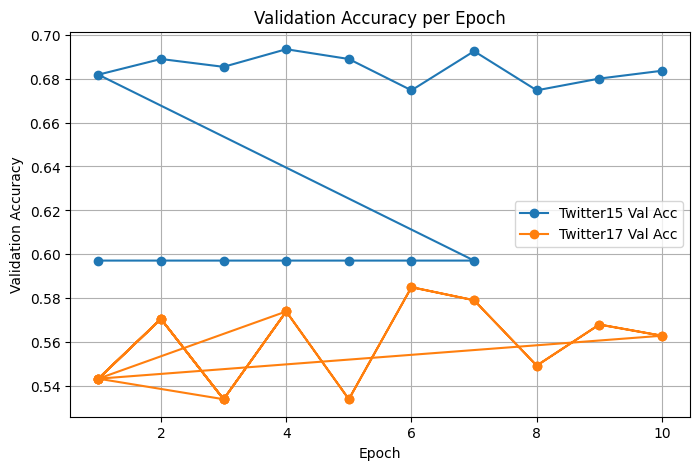

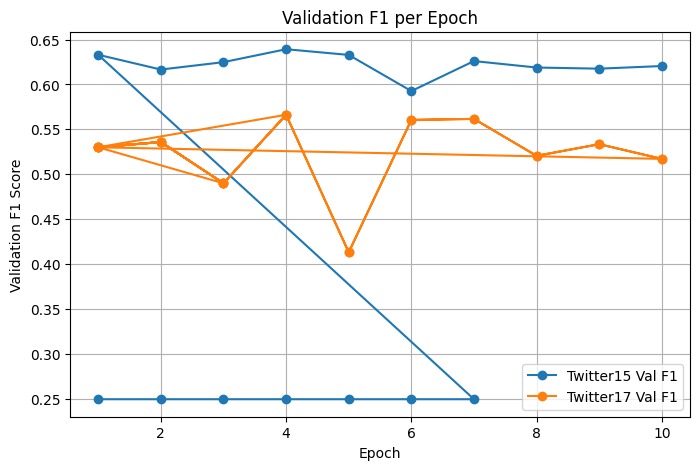

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load your log files from Google Drive
t15 = pd.read_csv("/content/drive/MyDrive/MSA/DPFN-main/result/twitter15_training_log.csv")
t17 = pd.read_csv("/content/drive/MyDrive/MSA/DPFN-main/result/twitter17_training_log.csv")

# ============================
# 📈 Validation Accuracy Plot
# ============================
plt.figure(figsize=(8,5))
plt.plot(t15["epoch"], t15["val_acc"], marker='o', label="Twitter15 Val Acc")
plt.plot(t17["epoch"], t17["val_acc"], marker='o', label="Twitter17 Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 📊 Validation F1 Plot
# ============================
plt.figure(figsize=(8,5))
plt.plot(t15["epoch"], t15["val_f1"], marker='o', label="Twitter15 Val F1")
plt.plot(t17["epoch"], t17["val_f1"], marker='o', label="Twitter17 Val F1")
plt.xlabel("Epoch")
plt.ylabel("Validation F1 Score")
plt.title("Validation F1 per Epoch")
plt.legend()
plt.grid(True)
plt.show()


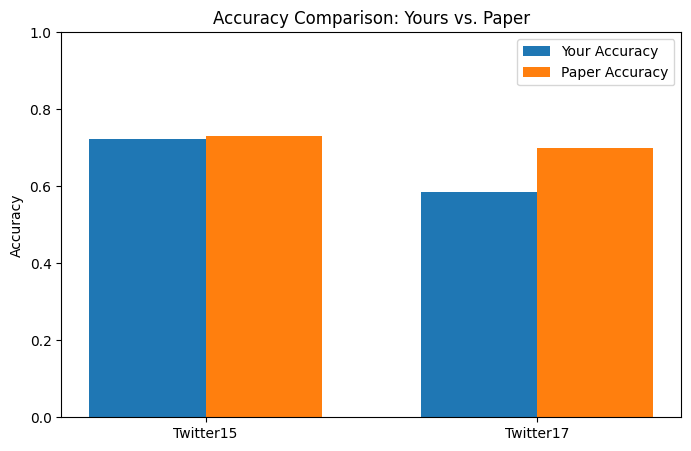

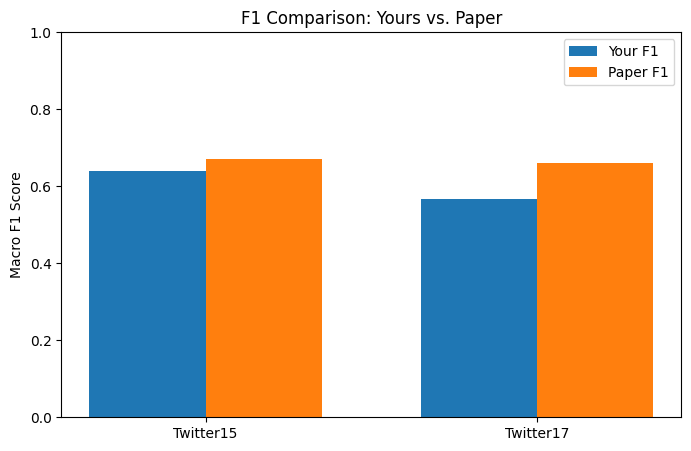

In [ ]:
# Your results (best from training logs)
my_results = {
    "Twitter15": {"Accuracy": 0.724, "F1": 0.639},
    "Twitter17": {"Accuracy": 0.585, "F1": 0.566},
}

# Paper-reported results (from DPFN paper)
paper_results = {
    "Twitter15": {"Accuracy": 0.73, "F1": 0.67},
    "Twitter17": {"Accuracy": 0.70, "F1": 0.66},
}

import numpy as np

datasets = ["Twitter15", "Twitter17"]
x = np.arange(len(datasets))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, [my_results[d]["Accuracy"] for d in datasets], width, label="Your Accuracy")
plt.bar(x + width/2, [paper_results[d]["Accuracy"] for d in datasets], width, label="Paper Accuracy")
plt.xticks(x, datasets)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Yours vs. Paper")
plt.legend()
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(8,5))
plt.bar(x - width/2, [my_results[d]["F1"] for d in datasets], width, label="Your F1")
plt.bar(x + width/2, [paper_results[d]["F1"] for d in datasets], width, label="Paper F1")
plt.xticks(x, datasets)
plt.ylabel("Macro F1 Score")
plt.title("F1 Comparison: Yours vs. Paper")
plt.legend()
plt.ylim(0,1)
plt.show()
